In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen, HTTPError, URLError
from urllib.parse import urlparse
import re
from concurrent.futures import ThreadPoolExecutor, TimeoutError
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import random






%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [ ]:
twt_data = pd.read_csv('../../../DataSets/twt_train.csv')
twt_data_with_links_saved = pd.read_csv('../../../DataSets/twt_with_links.csv')

In [ ]:
twt_data

In [ ]:
twt_data.describe()

In [ ]:
twt_data.info()

In [ ]:
def obtain_link(twt):
    url = re.search("(?P<url>https?://[^\s]+)", twt)
    return url.group("url") if url else np.NaN  

In [ ]:
twt_data['link'] = twt_data['text'].map(obtain_link)
twt_data

In [ ]:
twt_data.info()

In [ ]:
def isShorted(link):
    if link != link: return np.NaN 
    return 't.co' in str(link)

In [ ]:
twt_data['link_shorted'] = twt_data['link'].map(isShorted)


In [ ]:
twt_data

In [ ]:
twt_data_with_links = twt_data.dropna(subset=['link'])
twt_data_with_links

In [ ]:
twt_data_with_links = twt_data_with_links[twt_data_with_links['link_shorted']]
twt_data_with_links

In [ ]:
twt_data_with_links.info()

In [ ]:
twt_data_with_links['real_link'] = 'np.NaN'
twt_data_with_links['error'] = 'np.NaN'
twt_data_with_links['page'] = 'np.NaN'
twt_data_with_links = twt_data_with_links.reset_index()
twt_data_with_links.info()

In [ ]:
def obtain_real_link(index, url):
    try:
        with urlopen(url, timeout = 20) as response:
            actual_url = response.geturl()
            error = np.NaN
            page = response.read()
    except HTTPError as e:
        actual_url = e.url
        error = e
        page = np.NaN
    except URLError as e:
        actual_url = url
        error = e
        page = np.NaN
    except:
        actual_url = url
        error = 'OTHER_ERROR'
        page = np.NaN
    return (index, actual_url, error, page)

In [ ]:
def doWork(row):
    return obtain_real_link(row[0], row[1]['link'])

In [ ]:
twt_data_with_links_saved

In [ ]:
twt_data_with_links.head()

In [ ]:
twt_data_with_links.info()

In [ ]:
twt_data_with_links['site'] = twt_data_with_links['real_link'].map(lambda x: urlparse(x).netloc)
twt_data_with_links

In [ ]:
twt_data_with_links['site'].value_counts()

In [ ]:
twt_data_with_links.loc[twt_data_with_links['error'] != twt_data_with_links['error'], 'site'].value_counts()

In [ ]:
twt_data_with_links['target'].value_counts()

In [ ]:
twt_data_with_links.loc[twt_data_with_links['error'] != twt_data_with_links['error'], 'target'].value_counts()

In [ ]:
twt_data_with_links_saved = twt_data_with_links_saved.loc[twt_data_with_links_saved['error'] != twt_data_with_links_saved['error']]
twt_data_with_links_saved

In [ ]:
def get_the_header(page):
    soup = BeautifulSoup(page, "lxml")
    header = str(soup.h1.string) if soup.h1 else ''
    soup.decompose()
    return header

In [ ]:
twt_data_with_links_saved['header'] = twt_data_with_links_saved['page'].map(get_the_header)
twt_data_with_links_saved

In [ ]:
twt_data_with_links_saved.to_csv('../../../DataSets/twt_with_header.csv')

In [ ]:
twt_data_with_links_saved = twt_data_with_links_saved.loc[twt_data_with_links_saved["header"] != 'None']
twt_data_with_links_saved = twt_data_with_links_saved.loc[twt_data_with_links_saved["header"] != '']
twt_data_with_links_saved

In [ ]:
#repeticion_de_palabras
twt_data_with_links_saved["header"] = twt_data_with_links_saved["header"].str.lower().str.strip() #transformo todas las palabras a minuscula
twt_data_with_links_saved["header"] = twt_data_with_links_saved["header"].apply(lambda x: re.sub(r'[^\w]', ' ', x)) #quito todos los caracteres no alfanumericos
twt_data_with_links_saved["header"] = twt_data_with_links_saved["header"].apply(lambda x: re.sub(r'_', ' ', x))
twt_data_with_links_saved["header"] = twt_data_with_links_saved["header"].apply(lambda x: re.sub(r'[0-9]',' ', x)) #quito los caracteres numericos
twt_data_with_links_saved["header"] = twt_data_with_links_saved["header"].apply(lambda s: re.sub(r'\b\w{1}\b', '', s)) #quito las letras sueltas
twt_data_with_links_saved["header"] = twt_data_with_links_saved["header"].apply(lambda x: re.sub(' +',' ', x)) #quito los espacios de mas
twt_data_with_links_saved["header"] = twt_data_with_links_saved["header"].apply(lambda s: re.sub(r'\b\w{1,2}\b', '', s)) #quito las palabras cortas


In [ ]:
twt_data_with_links_saved['header_splited'] = twt_data_with_links_saved['header'].str.split(' ')
twt_data_with_links_saved

In [ ]:
list_stopwords = ["the","and","you","for","that","with","this","from","are","have","was","like","but","just","not","your",\
                 "all","after","will","can","has","when","they","get","new","now","what","amp","","http","https","out",\
                 "more","about","how","there","don","over","into","than","would","been","her","who","were","some","still",\
                 "his","back","why","them","got","know","had","see","going","our","htt","via","nws","wait",\
                 "hwy","top","both","hah","haha","getting","far","near", "video", "unavailable", "is"]
def count_words(word, count):
    if(word in list_stopwords):
        return
    if (word in count):
        count[word] = count[word] + 1
        return
    count[word] = 1
        

In [ ]:
total_word_count = {}
twt_data_with_links_saved['header_splited'].map(
    lambda x: [count_words(word, total_word_count) for word in x]
)
total_word_count

In [ ]:
disaster_word_count = {}
twt_data_with_links_saved.loc[twt_data_with_links_saved['target'] == 1,'header_splited'].map(
    lambda x: [count_words(word, disaster_word_count) for word in x] if (x != None) else None
)
disaster_word_count

In [ ]:
normal_word_count = {}
twt_data_with_links_saved.loc[twt_data_with_links_saved['target'] == 0,'header_splited'].map(
    lambda x: [count_words(word, normal_word_count) for word in x] if (x != None) else None
)
normal_word_count

In [ ]:
{k: v for k, v in sorted(normal_word_count.items(), key=lambda item: item[1], reverse = True)}


In [ ]:
{k: v for k, v in sorted(disaster_word_count.items(), key=lambda item: item[1], reverse = True)}


In [ ]:
{k: v for k, v in sorted(total_word_count.items(), key=lambda item: item[1], reverse = True)}


In [ ]:
twt_data.head()

In [ ]:
twt_data['for_graphics'] = 1
grouped_twt = twt_data.groupby('target').sum().reset_index()
g = sns.barplot(x='target', y='for_graphics', data=grouped_twt)
for index, row in grouped_twt.iterrows():
    g.text(row.target, row.for_graphics, row.for_graphics, color='black', ha="center")
g.set_title("Cantidad de tweets segun su target", fontsize=16, pad=20)
g.set_xlabel("Target", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)

In [ ]:
def is_not_nan(value):
    return value == value

In [ ]:
twt_data['with_link'] = twt_data['link'].map(is_not_nan)
twt_data

In [ ]:
grouped_twt = twt_data.groupby('with_link').sum().reset_index()
g = sns.barplot(x='with_link', y='for_graphics', data=grouped_twt)
for index, row in grouped_twt.iterrows():
    g.text(row.name, row.for_graphics, row.for_graphics, color='black', ha="center")
g.set_title("Cantidad de tweets segun la existencia de links", fontsize=16, pad=20)
g.set_xlabel("Tiene link?", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)

In [ ]:
grouped_twt = twt_data.groupby(['target', 'with_link']).sum().reset_index()
g = sns.barplot(x='target', y='for_graphics', hue='with_link', data=grouped_twt)
g.set_title("Cantidad de tweets segun su target y si tiene link", fontsize=16, pad=20)
g.set_xlabel("Target", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)

In [ ]:
grouped_by_target_twt = twt_data.groupby(['target']).sum().reset_index()
grouped_by_links_twt = twt_data.groupby(['target', 'with_link']).sum().reset_index()


In [ ]:
grouped_by_target_twt

In [ ]:
grouped_by_links_twt

In [ ]:
grouped_by_links_twt.loc[grouped_by_links_twt['with_link'] == False, 'for_graphics'] = grouped_by_target_twt.loc[:, 'for_graphics']
grouped_by_links_twt

In [ ]:
grouped_by_links_twt.loc[grouped_by_links_twt['with_link'] == False, 'for_graphics'] = grouped_by_target_twt['for_graphics'].tolist()
grouped_by_links_twt.loc[grouped_by_links_twt['with_link'] == False, 'with_link'] = 'Total'
grouped_by_links_twt

In [ ]:
g = sns.barplot(x = 'target', y = 'for_graphics', data=grouped_by_links_twt, hue='with_link', dodge=False)
g.set_title("Cantidad de tweets segun la existencia de links", fontsize=16, pad=20)
g.set_xlabel("Tiene link?", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)

In [ ]:
g = sns.barplot(x = 'target', y = 'for_graphics', data=grouped_by_links_twt, hue='with_link')
g.set_title("Cantidad de tweets segun la existencia de links", fontsize=16, pad=20)
g.set_xlabel("Tiene link?", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)

In [ ]:
twt_with_link = grouped_by_links_twt.loc[grouped_by_links_twt['with_link'] == True]
g = sns.barplot(x = 'target', y = 'for_graphics', data=twt_with_link)
g.set_title("Cantidad de tweets que contienen link segun el target", fontsize=16, pad=20)
g.set_xlabel("Target", fontsize=14)
g.set_ylabel("Cantidad", fontsize=14)
for index, row in twt_with_link.iterrows():
    g.text(row.target, row.for_graphics, row.for_graphics, color='black', ha="center")

A continuacion trabajaremos exclusivamente con los twits que poseen links

In [ ]:
twt_data_with_links = twt_data_with_links.drop(columns=['Unnamed: 0'])
twt_data_with_links['for_graphics'] = 1
twt_data_with_links

In [ ]:
grouped_by_sites = twt_data_with_links.groupby('site').sum()
grouped_by_sites

In [ ]:
sites_top_20 = grouped_by_sites.sort_values('for_graphics', ascending=False).head(20).reset_index()
sites_top_20

In [ ]:
g = sns.barplot(x = 'for_graphics', y = 'site', data=sites_top_20)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

Dejaremos afuera el sition t.co y los que tienen como sitio twitter.com y error 

In [ ]:
def filter_twitter_error(row):
    return row.site != 't.co' and (row.site != 'twitter.com' or row.error != row.error)

In [ ]:
filter_list = []
for index, row in twt_data_with_links.iterrows():
    filter_list.append(filter_twitter_error(row))
twt_data_with_links.loc[filter_list]

In [ ]:
sites_top_20_filtered = twt_data_with_links.loc[filter_list].groupby('site').sum()\
    .sort_values('for_graphics', ascending=False).head(20).reset_index()
g = sns.barplot(x = 'for_graphics', y = 'site', data=sites_top_20_filtered)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

In [ ]:
sites_top_20_filtered = twt_data_with_links.loc[filter_list].loc[twt_data_with_links['target']==1].groupby('site')\
    .sum().sort_values('for_graphics', ascending=False).head(20).reset_index()
g = sns.barplot(x = 'for_graphics', y = 'site', data=sites_top_20_filtered)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

In [ ]:
sites_top_20_filtered = twt_data_with_links.loc[filter_list].loc[twt_data_with_links['target']==0].groupby('site')\
    .sum().sort_values('for_graphics', ascending=False).head(20).reset_index()
g = sns.barplot(x = 'for_graphics', y = 'site', data=sites_top_20_filtered)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

A continuacion nos quedaremos solo con las lineas que no contienen errores ya que analizaremos las paginas

In [ ]:
twt_data_with_links

In [ ]:
twt_data_with_links_saved.drop(columns=['Unnamed: 0'], inplace=True)
twt_data_with_links_saved

In [ ]:
total_header_words = pd.DataFrame(list(total_word_count.items()), index=range(len(total_word_count.items())),\
                                  columns=['word', 'count'])
disaster_header_words = pd.DataFrame(list(disaster_word_count.items()), index=range(len(disaster_word_count.items())),\
                                  columns=['word', 'count'])
normal_header_words = pd.DataFrame(list(normal_word_count.items()), index=range(len(normal_word_count.items())),\
                                  columns=['word', 'count'])
total_header_words

In [ ]:
disaster_header_words

In [ ]:
normal_header_words

In [ ]:
words_top_20 = total_header_words.sort_values('count', ascending=False).head(20).reset_index()
g = sns.barplot(x = 'count', y = 'word', data=words_top_20)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

In [ ]:
words_top_20 = disaster_header_words.sort_values('count', ascending=False).head(20).reset_index()
g = sns.barplot(x = 'count', y = 'word', data=words_top_20)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

In [ ]:
words_top_20 = normal_header_words.sort_values('count', ascending=False).head(20).reset_index()
g = sns.barplot(x = 'count', y = 'word', data=words_top_20)
g.set_title("Top 20 de sitios mas linkeados a los tweets", fontsize=16, pad=20)
g.set_xlabel("Cantidad", fontsize=14)
g.set_ylabel("Sitios", fontsize=14)

In [ ]:
#palabras mas usadas en tweets no tienen que ver con desastres reales
wordcloud = WordCloud(width = 500, height = 500, min_font_size = 5, max_font_size = 70, max_words = 1000, 
                      background_color = 'black', stopwords = list_stopwords).generate_from_frequencies(normal_word_count)
fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
#palabras mas usadas en tweets no tienen que ver con desastres reales
mask = np.array(Image.open(('../../../DataSets/twitter.png')))
wordcloud = WordCloud(width = 500, height = 500, min_font_size = 5, max_font_size = 70, max_words = 1000, 
                      background_color = 'black', mask=mask, stopwords = list_stopwords)\
                        .generate_from_frequencies(disaster_word_count)
fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k')
plt.imshow(wordcloud.recolor(color_func=twitter_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
def twitter_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(197, 100%%, %d%%)" % random.randint(60, 100)

A continuacion algunos histogramas

In [ ]:
g = sns.distplot(list(disaster_word_count.values()), hist=True, kde=False, bins=20)
g.set_title('Distribucion de la cantidad de veces que aparece una palabra durante un desastre',\
            fontsize=16, pad=20)
g.set_ylabel('Densidad', fontsize=18)
g.set_yscale('log')
g.set_xlabel('Longitud', fontsize=18)

In [ ]:
g = sns.distplot(list(normal_word_count.values()), hist=True, kde=False, bins=10)
g.set_title('Distribucion de la cantidad de veces que aparece una palabra durante un normalidad',\
            fontsize=16, pad=20)
g.set_ylabel('Densidad', fontsize=18)
g.set_yscale('log')
g.set_xlabel('Longitud', fontsize=18)

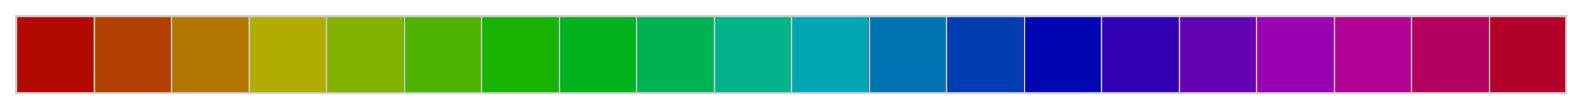

In [4]:
sns.palplot(sns.hls_palette(20, l=0.35, s=1))